# Time series analysis

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Data

In [69]:
data= pd.read_csv("data4.csv", sep=';', header=None)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   object 
 1   1       1001 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [71]:
data.head()

,0,1
0,NaN,0.00
1,2023-01-01,0.00
2,2023-01-02,0.59
3,2023-01-03,-0.24
4,2023-01-04,0.23


In [72]:
print(data.isnull().sum())

0    1
1    0
dtype: int64


In [73]:
data = data.iloc[1:].reset_index(drop=True) # rimuove prima riga con NaN

# Converte le colonne
data.iloc[:, 0] = pd.to_datetime(data.iloc[:, 0], errors="coerce")
data.iloc[:, 1] = pd.to_numeric(data.iloc[:, 1], errors="coerce")

# Rinomina le colonne
data.columns = ["date", "value"]

# Imposta l'indice
data = data.set_index("date")

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-01-01 to 2025-09-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [75]:
data.head()

,value
date,
2023-01-01,0.00
2023-01-02,0.59
2023-01-03,-0.24
2023-01-04,0.23
2023-01-05,-0.41


# Plot data

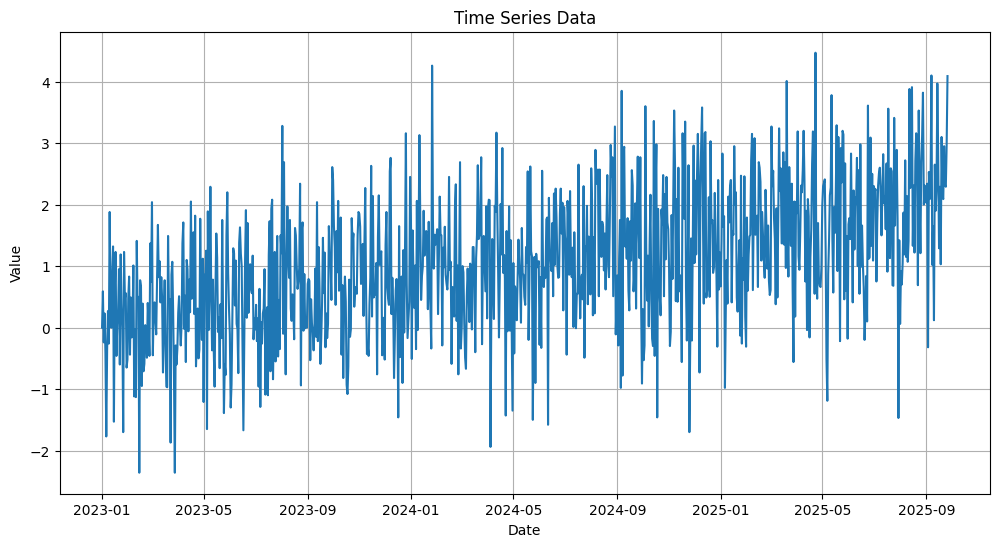

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Stationarity

Sono stati effettuati i test ADF (Augmented Dickey-Fuller) e KPSS (Kwiatkowski-Phillips-Schmidt-Shin) per valutare la stazionarietà della serie temporale.

- ADF: statistic = -2.301, p-value = 0.172
L’ADF non permette di rifiutare l’ipotesi nulla di non-stazionarietà.

- KPSS: statistic = 5.042, p-value ≈ 0.01
La KPSS rifiuta l’ipotesi nulla di stazionarietà.

Entrambi i test indicano che la serie non è stazionaria, mostrando un trend.
Scelta modellistica:


La serie è stata quindi scomposta in due componenti:

- Trend lineare, stimato tramite OLS (regressione sul tempo, senza intercetta significativa).

- viene testata la stazionarietà di et = yt-Tt

- I residui sono modellati con ARIMA.



In [77]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

adf_test(data['value'])

ADF Statistic: -2.301342
p-value: 0.171536
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
The series is likely non-stationary.


In [78]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Num Lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')
    if p_value < 0.05:
        print("The series is likely non-stationary (reject H0).")
    else:
        print("The series is likely stationary (fail to reject H0).")

kpss_test(data['value'])

KPSS Statistic: 5.04167384166966
p-value: 0.01
Num Lags: 15
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely non-stationary (reject H0).


/tmp/ipython-input-1988008985.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


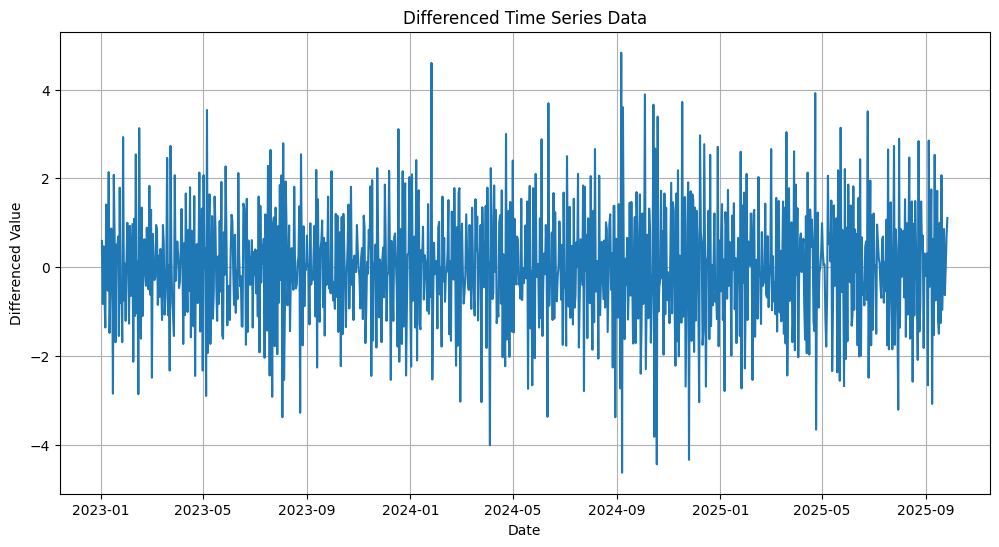

ADF test on differenced series:
ADF Statistic: -11.079951
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
The series is likely stationary.

KPSS test on differenced series:
KPSS Statistic: 0.07670841061669982
p-value: 0.1
Num Lags: 76
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary (fail to reject H0).


/tmp/ipython-input-1988008985.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [79]:
# Differenzia la serie storica
data['value_diff'] = data['value'].diff().dropna()

# Plot della serie differenziata
plt.figure(figsize=(12, 6))
plt.plot(data['value_diff'])
plt.title('Differenced Time Series Data')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

# Test di stazionarietà sulla serie differenziata
print("ADF test on differenced series:")
adf_test(data['value_diff'].dropna()) # Drop NaNs before testing

print("\nKPSS test on differenced series:")
kpss_test(data['value_diff'].dropna()) # Drop NaNs before testing

# Model

## Formula finale del modello

l modello elaborato combina le componenti:

Serie=Trend (OLS)+Residui (ARIMA)+Residui(causali)

Il trend descrive l’andamento di lungo periodo.

L’ARIMA cattura le fluttuazioni attorno al trend.

I residui finali risultano compatibili con rumore bianco, indicando che la struttura della serie è stata adeguatamente modellata.



La serie è modellata come combinazione di trend lineare e ARIMA(3,0,2) sui residui:

$$
y_t = \beta \, t +
\underbrace{
\phi_1 \, \varepsilon_{t-1} +
\phi_2 \, \varepsilon_{t-2} +
\phi_3 \, \varepsilon_{t-3} +
\theta_1 \, e_{t-1} +
\theta_2 \, e_{t-2} +
e_t
}_{\text{ARIMA(3,0,2) sui residui}}
$$

dove:  

- $\beta$ = coefficiente della regressione lineare sul tempo (trend) senza intercetta  
- $\phi_1, \phi_2, \phi_3$ = parametri AR (autoregressivi)  
- $\theta_1, \theta_2$ = parametri MA (media mobile)  
- $e_t$ = rumore bianco  


## Trend Modeling with OLS

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assumi 'data' con colonna 'value'
data['time'] = np.arange(len(data))

# -------------------------
# Trend lineare
X = sm.add_constant(data['time'])
ols_model = sm.OLS(data['value'], X).fit()
trend = ols_model.predict(X)

# -------------------------
# Residui del trend
resid = data['value'] - trend

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     301.2
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           3.62e-59
Time:                        16:01:49   Log-Likelihood:                -1410.4
No. Observations:                1000   AIC:                             2825.
Df Residuals:                     998   BIC:                             2835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1170      0.063      1.865      0.0

Residui calcolati dal modello OLS con intercetta.


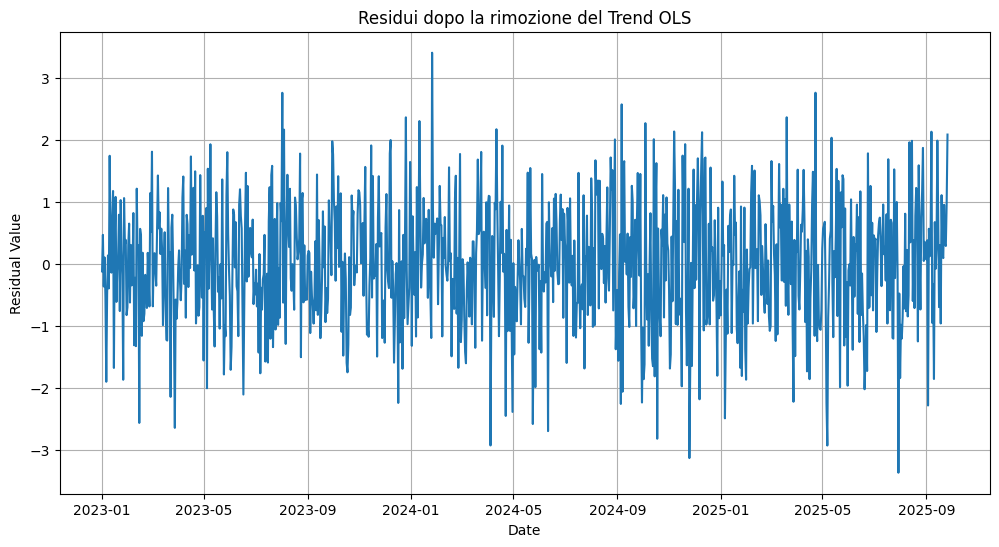


ADF test sui residui dopo rimozione trend OLS:
ADF Statistic: -8.880647
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
The series is likely stationary.

KPSS test sui residui dopo rimozione trend OLS:
KPSS Statistic: 0.036821572427973605
p-value: 0.1
Num Lags: 3
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is likely stationary (fail to reject H0).


/tmp/ipython-input-1988008985.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [81]:
if 'ols_model' in locals():

    X_all = sm.add_constant(pd.DataFrame({'time': np.arange(len(data))}, index=data.index))
    trend_all = ols_model.predict(X_all)
    resid_after_ols = data['value'] - trend_all
    print("Residui calcolati dal modello OLS con intercetta.")
else:
    print("Nessun modello OLS trovato. Eseguire prima il codice per il fit del modello OLS.")
    resid_after_ols = None # Imposta a None per evitare errori successivi

if resid_after_ols is not None:
    # Plot dei residui dopo la rimozione del trend OLS
    plt.figure(figsize=(12, 6))
    plt.plot(resid_after_ols)
    plt.title('Residui dopo la rimozione del Trend OLS')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.grid(True)
    plt.show()

    # Test di stazionarietà sui residui
    print("\nADF test sui residui dopo rimozione trend OLS:")
    adf_test(resid_after_ols.dropna()) # Drop NaNs before testing

    print("\nKPSS test sui residui dopo rimozione trend OLS:")
    kpss_test(resid_after_ols.dropna()) # Drop NaNs before testing

Questi test ti mostreranno se i residui del trend OLS sono stazionari. Se lo sono, significa che il trend lineare ha catturato la componente non stazionaria e i residui possono essere modellati con un modello ARIMA stazionario.

## Residual modeling with ARIMA

In [82]:
from statsmodels.tsa.arima.model import ARIMA
# -------------------------
# ARIMA(3,0,2) sui residui
arima_model = ARIMA(resid, order=(3,0,2))
arima_result = arima_model.fit()
print(arima_result.summary())
# -------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1400.851
Date:                Wed, 08 Oct 2025   AIC                           2815.701
Time:                        16:01:50   BIC                           2850.056
Sample:                    01-01-2023   HQIC                          2828.758
                         - 09-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.325e-05      0.033     -0.000      1.000      -0.065       0.065
ar.L1         -0.6829      0.048    -14.262      0.000      -0.777      -0.589
ar.L2         -0.8572      0.051    -16.851      0.0

## White noise residual

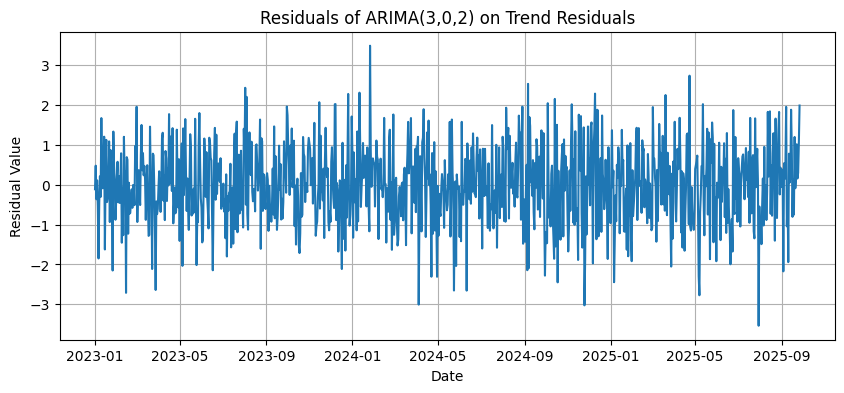

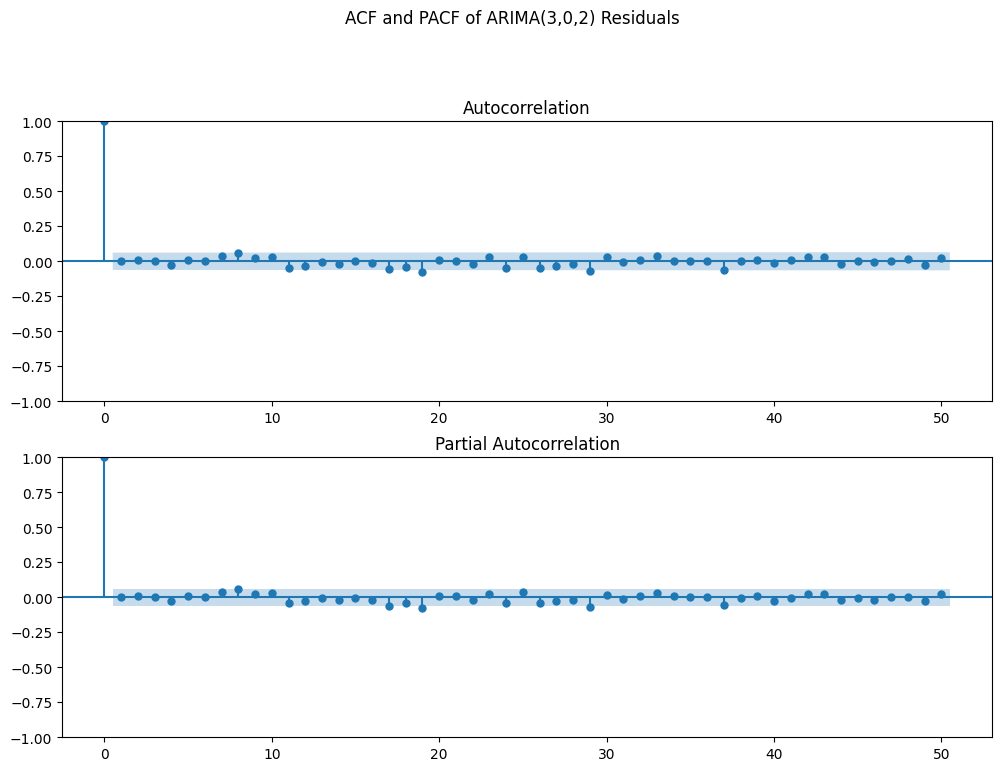


Ljung-Box test on ARIMA(3,0,2) residuals:
      lb_stat  lb_pvalue
10   7.187309   0.707651
20  22.151175   0.332364
30  36.332168   0.197403


In [83]:
# Get the residuals from the ARIMA model fitted to the trend residuals
arima_residuals = arima_result.resid

# Plot the residuals
plt.figure(figsize=(10, 4))
plt.plot(arima_residuals)
plt.title("Residuals of ARIMA(3,0,2) on Trend Residuals")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.grid(True)
plt.show()

# Plot ACF and PACF of the residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(arima_residuals, lags=50, ax=ax[0])
plot_pacf(arima_residuals, lags=50, ax=ax[1])
plt.suptitle("ACF and PACF of ARIMA(3,0,2) Residuals", y=1.02)
plt.show()

# Perform Ljung-Box test on the residuals
ljungbox_test_residuals = acorr_ljungbox(arima_residuals, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box test on ARIMA(3,0,2) residuals:")
print(ljungbox_test_residuals)

# Combined Model Forecasting (OLS without Intercept + ARIMA on Residuals)

La serie è stata modellata combinando un trend lineare stimato tramite OLS (senza intercetta, non significativa) con un modello ARIMA(3,0,2) applicato ai residui. Il trend cattura l’andamento di lungo periodo, mentre l’ARIMA descrive le fluttuazioni a breve termine. I residui finali risultano compatibili con rumore bianco e le metriche di previsione sul test set (RMSE = 1.034, MAE = 0.824) indicano che il modello rappresenta in modo soddisfacente la dinamica osservata della serie.

OLS Model Summary (without Intercept):
                                 OLS Regression Results                                
Dep. Variable:                  value   R-squared (uncentered):                   0.432
Model:                            OLS   Adj. R-squared (uncentered):              0.432
Method:                 Least Squares   F-statistic:                              532.4
Date:                Wed, 08 Oct 2025   Prob (F-statistic):                    5.08e-88
Time:                        16:01:51   Log-Likelihood:                         -978.23
No. Observations:                 700   AIC:                                      1958.
Df Residuals:                     699   BIC:                                      1963.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using


ARIMA Model Summary on Residuals (from OLS without Intercept):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  700
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -969.045
Date:                Wed, 08 Oct 2025   AIC                           1952.090
Time:                        16:01:52   BIC                           1983.947
Sample:                    01-01-2023   HQIC                          1964.405
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.039      0.877      0.380      -0.042       0.110
ar.L1         -0.7026      0.045    -15.679      0.000      -0.790 

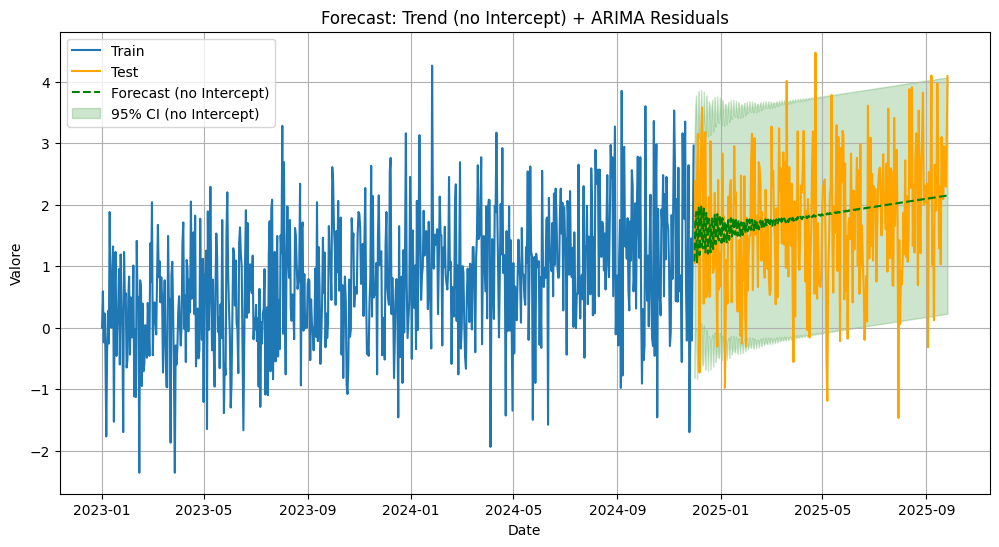

In [84]:


# Definizione train/test (70% train, 30% test)

test_percentage = 0.3
test_size = int(len(data) * test_percentage)
train_data = data.iloc[:-test_size].copy()
test_data = data.iloc[-test_size:].copy()


# Fit OLS sul train set (trend lineare senza costante)

train_data['time'] = np.arange(len(train_data))
y_train = train_data['value']
X_train = train_data[['time']] # Rimuovi la costante
ols_model_no_intercept = sm.OLS(y_train, X_train).fit()
trend_train_no_intercept = ols_model_no_intercept.predict(X_train)
resid_train_no_intercept = y_train - trend_train_no_intercept

print("OLS Model Summary (without Intercept):")
print(ols_model_no_intercept.summary())

# Fit ARIMA sui residui train (dal modello OLS senza costante)
# Using the same ARIMA order (3,0,2) as before

arima_model_resid_no_intercept = ARIMA(resid_train_no_intercept, order=(3,0,2))
arima_result_resid_no_intercept = arima_model_resid_no_intercept.fit()

print("\nARIMA Model Summary on Residuals (from OLS without Intercept):")
print(arima_result_resid_no_intercept.summary())


#  Forecast sul test set

#  Trend forecast (from OLS without intercept)
forecast_time = np.arange(len(train_data), len(train_data) + len(test_data))
X_forecast = pd.DataFrame({'time': forecast_time}, index=test_data.index) # Add index
trend_forecast_no_intercept = ols_model_no_intercept.predict(X_forecast)

# ARIMA residui forecast con intervalli di confidenza
arima_forecast_result_no_intercept = arima_result_resid_no_intercept.get_forecast(steps=len(test_data))
resid_forecast_no_intercept = arima_forecast_result_no_intercept.predicted_mean
resid_ci_no_intercept = arima_forecast_result_no_intercept.conf_int(alpha=0.05)

# Ensure the index of ARIMA residual forecast matches the test data index
resid_forecast_no_intercept.index = test_data.index
resid_ci_no_intercept.index = test_data.index


# Combine trend + residui ARIMA
combined_forecast_no_intercept = trend_forecast_no_intercept + resid_forecast_no_intercept
lower_no_intercept = trend_forecast_no_intercept + resid_ci_no_intercept.iloc[:, 0]
upper_no_intercept = trend_forecast_no_intercept + resid_ci_no_intercept.iloc[:, 1]

# Metriche di valutazione
rmse_combined_no_intercept = sqrt(mean_squared_error(test_data['value'], combined_forecast_no_intercept))
mae_combined_no_intercept = mean_absolute_error(test_data['value'], combined_forecast_no_intercept)

print(f'\nCombined Model (no Intercept) RMSE: {rmse_combined_no_intercept:.4f}')
print(f'\nCombined Model (no Intercept) MAE: {mae_combined_no_intercept:.4f}')

#  Plot forecast con intervalli di confidenza
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['value'], label='Train')
plt.plot(test_data.index, test_data['value'], label='Test', color='orange')
plt.plot(test_data.index, combined_forecast_no_intercept, color='green', linestyle='--', label='Forecast (no Intercept)')
plt.fill_between(test_data.index, lower_no_intercept, upper_no_intercept, color='green', alpha=0.2, label='95% CI (no Intercept)')
plt.title('Forecast: Trend (no Intercept) + ARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Valore')
plt.legend()
plt.grid(True)
plt.show()